# Extending Ibis Part 1: Adding a New Elementwise Expression

This notebook will show you how to add a new elementwise operation to an existing backend.

We are going to add `julianday`, a function supported by the SQLite database, to the SQLite Ibis backend.

The Julian day of a date, is the number of days since January 1st, 4713 BC. For more information check the [Julian day](https://en.wikipedia.org/wiki/Julian_day) wikipedia page.

## Step 1: Define the Operation

Let's define the `julianday` operation as a function that takes one string input argument and returns a float.

```python
def julianday(date: str) -> float:
    """Julian date"""
```

In [2]:
import ibis.expr.datatypes as dt
import ibis.expr.rules as rlz

from ibis.expr.operations import ValueOp, Arg


class JulianDay(ValueOp):
    arg = Arg(rlz.string)
    output_type = rlz.shape_like('arg', 'float')

We just defined a `JulianDay` class that takes one argument of type string or binary, and returns a float.

## Step 2: Define the API

Because we know the output type of the operation, to make an expression out of ``JulianDay`` we simply need to construct it and call its `ibis.expr.types.Node.to_expr` method.

We still need to add a method to `StringValue` and `BinaryValue` (this needs to work on both scalars and columns).

When you add a method to any of the expression classes whose name matches `*Value` both the scalar and column child classes will pick it up, making it easy to define operations for both scalars and columns in one place.

We can do this by defining a function and assigning it to the appropriate class
of expressions.


In [3]:
from ibis.expr.types import StringValue, BinaryValue


def julianday(string_value):
    return JulianDay(string_value).to_expr()


StringValue.julianday = julianday

## Interlude: Create some expressions with `sha1`

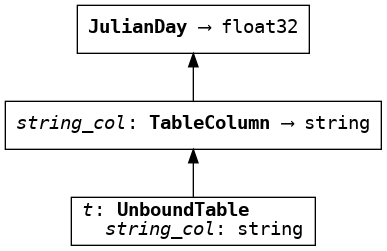

In [4]:
import ibis

t = ibis.table([('string_col', 'string')], name='t')

t.string_col.julianday()

## Step 3: Turn the Expression into SQL

In [9]:
ibis.sqlite.client._compiler

ibis.backends.sqlite.compiler.SQLiteCompiler

In [5]:
import sqlalchemy as sa


@ibis.sqlite.add_operation(JulianDay)
def _julianday(translator, expr):
    # pull out the arguments to the expression
    arg, = expr.op().args
    
    # compile the argument
    compiled_arg = translator.translate(arg)
    
    # return a SQLAlchemy expression that calls into the SQLite julianday function
    return sa.func.julianday(compiled_arg)

RuntimeError: Only SQL-based backends support `add_operation`

## Step 4: Putting it all Together

In [ ]:
import pathlib
import ibis

db_fname = str(pathlib.Path().resolve().parent.parent / 'tutorial' / 'data' / 'geography.db')

con = ibis.sqlite.connect(db_fname)

### Create and execute a `julianday` expression

In [ ]:
independence = con.table('independence')
independence

In [ ]:
day = independence.independence_date.cast('string')
day

In [ ]:
julianday_expr = day.julianday()
julianday_expr

In [ ]:
sql_expr = julianday_expr.compile()
print(sql_expr)

In [ ]:
result = julianday_expr.execute()
result.head()

Because we've defined our operation on `StringValue`, and not just on `StringColumn` we get operations on both string scalars *and* string columns for free

In [ ]:
scalar = ibis.literal('2010-03-14')
scalar

In [ ]:
julianday_scalar = scalar.julianday()

In [ ]:
con.execute(julianday_scalar)